In [ ]:
!pip install datasets

In [ ]:
import pandas as pd
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch.nn.utils.rnn import pad_sequence
import torch
import torch.nn as nn
from transformers import AutoModel
from transformers import AutoTokenizer
from datasets import load_dataset
import torch
from transformers import BertTokenizerFast, BertConfig
from transformers import BertPreTrainedModel, BertModel
from sklearn.metrics import precision_recall_fscore_support
import numpy as np
from datasets import load_from_disk
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModel
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

import json
import torch
from transformers import AutoModel

In [ ]:
import os
from datetime import datetime

# Get the current date
today = datetime.now().date()  # This will give only the date part

# Format the date
date_stamp = today.strftime("%Y_%m_%d")  # e.g., "20240501"


model_name = 'microsoft_BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext'#'google-bert_bert-base-uncased_novalidation_upsampling_2_DatasetV4'

# Combine the date stamp with a base folder name
base_folder_name = f"BioASQ_Output/Output_NNER_{model_name}_{date_stamp}"  # e.g., "Data_20240501"

# Create the directory
os.makedirs(base_folder_name, exist_ok=True)  # Creates the folder if it does not exist


In [ ]:


# Load the dataset from disk
path = 'Datasets/BioASQ/BioASQ_NNER_dict_separated_splitted_V4'  # Update this path to your actual file location


dataset_original = load_from_disk(path)
print(dataset_original['train'][0])
tag_list = ['O', 'B-DISO', 'I-DISO', 'B-CHEM', 'I-CHEM', 'B-ANATOMY', 'I-ANATOMY', 'B-FINDING', 'I-FINDING', 'B-LABPROC', 'I-LABPROC', 'B-PHYS', 'I-PHYS', 'B-INJURY_POISONING', 'I-INJURY_POISONING', 'B-DEVICE', 'I-DEVICE']
print(dataset_original)



{'id': '26978639_en_S1', 'tokens': ['OBJECTIVE', 'To', 'explore', 'the', 'correlations', 'between', 'plasma', 'cholesterol', 'and', 'triglyceride', 'levels', 'and', 'psychometric', 'assessments', 'in', 'patients', 'with', 'psychosomatic', 'illnesses', 'and', 'chronic', 'cerebral', 'ischemia', '(', 'CCI', ')', '.'], 'ner_tags1': [0, 0, 0, 0, 7, 8, 8, 8, 8, 8, 8, 0, 0, 0, 0, 0, 0, 1, 2, 0, 1, 2, 2, 0, 1, 0, 0], 'ner_tags2': [0, 0, 0, 0, 0, 0, 11, 12, 12, 12, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0], 'ner_tags3': [0, 0, 0, 0, 0, 0, 5, 3, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 1, 0, 0, 0, 0], 'ner_tags4': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'ner_tags5': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'ner_tags6': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags1', 'ner_tags2', 'ner_t

In [ ]:
from datasets import load_from_disk, concatenate_datasets

# Combine train and validation datasets
combined_train_dataset = concatenate_datasets([dataset_original['train'], dataset_original['validation']])

# Update dataset dictionary to only include the combined train dataset
#dataset = dataset.remove_columns(['validation'])
dataset_original['train'] = combined_train_dataset

print("Combined train dataset:")
print(dataset_original['train'][0])  # Show first example from the combined dataset

# Debug print to check structure and some data points
dataset_original


Combined train dataset:
{'id': '26978639_en_S1', 'tokens': ['OBJECTIVE', 'To', 'explore', 'the', 'correlations', 'between', 'plasma', 'cholesterol', 'and', 'triglyceride', 'levels', 'and', 'psychometric', 'assessments', 'in', 'patients', 'with', 'psychosomatic', 'illnesses', 'and', 'chronic', 'cerebral', 'ischemia', '(', 'CCI', ')', '.'], 'ner_tags1': [0, 0, 0, 0, 7, 8, 8, 8, 8, 8, 8, 0, 0, 0, 0, 0, 0, 1, 2, 0, 1, 2, 2, 0, 1, 0, 0], 'ner_tags2': [0, 0, 0, 0, 0, 0, 11, 12, 12, 12, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0], 'ner_tags3': [0, 0, 0, 0, 0, 0, 5, 3, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 1, 0, 0, 0, 0], 'ner_tags4': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'ner_tags5': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'ner_tags6': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}


DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags1', 'ner_tags2', 'ner_tags3', 'ner_tags4', 'ner_tags5', 'ner_tags6'],
        num_rows: 1083
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags1', 'ner_tags2', 'ner_tags3', 'ner_tags4', 'ner_tags5', 'ner_tags6'],
        num_rows: 217
    })
})

In [ ]:
import pandas as pd
from datasets import DatasetDict, Dataset

df_train = pd.DataFrame(dataset_original["train"])
df_val = pd.DataFrame(dataset_original["validation"])

# Define minority tags you want to focus on
minority_tags = {14, 16}  # Adjust this set according to your specific minority classes

# Multiplier: how many times to duplicate each minority instance
oversampling_multiplier = 2

# Function to check if any minority tags are in the list of tags
def contains_minority(tags_column):
    return any(tag in minority_tags for tag in tags_column)

# Apply the function to each row for each ner_tag column
for column in ['ner_tags1', 'ner_tags2', 'ner_tags3', 'ner_tags4', 'ner_tags5', 'ner_tags6']:
    # Find indices where minority tags exist
    minority_indices = df_train[column].apply(contains_minority)

    # Filter rows with minority tags
    minority_rows = df_train[minority_indices]

    # Append these rows multiple times based on the multiplier
    for _ in range(oversampling_multiplier):
        df_train = pd.concat([df_train, minority_rows], ignore_index=True)

    # Shuffle the DataFrame after concatenation
    df_train = df_train.sample(frac=1).reset_index(drop=True)

# Convert the modified DataFrame back to Dataset format
tds_resampled = Dataset.from_pandas(df_train)
vds = Dataset.from_pandas(df_val)

# Creating a new DatasetDict
dataset = DatasetDict({
    'train': tds_resampled,
    'validation': vds
})

print("Shuffled dataset after adding minority rows")
print(dataset)


Shuffled dataset after adding minority rows
DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags1', 'ner_tags2', 'ner_tags3', 'ner_tags4', 'ner_tags5', 'ner_tags6'],
        num_rows: 1231
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags1', 'ner_tags2', 'ner_tags3', 'ner_tags4', 'ner_tags5', 'ner_tags6'],
        num_rows: 217
    })
})


'from collections import Counter\n\ndef count_tag_occurrences_separately(dataset, tag_list):\n    # Initialize a dictionary to hold data for both train and validation splits\n    tag_counts = {\n        \'train\': {f\'ner_tags{i}\': Counter() for i in range(1, 7)},\n        \'validation\': {f\'ner_tags{i}\': Counter() for i in range(1, 7)}\n    }\n\n    # Process each split separately\n    for split in [\'train\', \'validation\']:\n        # Iterate over each record in the split\n        for record in dataset[split]:\n            # Count tags for each ner_tags field\n            for i in range(1, 7):\n                tag_field = f\'ner_tags{i}\'\n                tags = record[tag_field]\n                tag_counts[split][tag_field].update([tag_list[tag] for tag in tags])\n\n    return tag_counts\n\n# Assuming dataset is already loaded as \'dataset\'\ntag_counts = count_tag_occurrences_separately(dataset, tag_list)\nfor split in tag_counts:\n    print(f"Split: {split}")\n    for key, va

'df=pd.DataFrame(dataset[\'validation\'] )\nsentences_must_be_in_train = []\nprint(df.head())\nner_columns = ["ner_tags1", "ner_tags2", "ner_tags3", "ner_tags4", "ner_tags5", "ner_tags6"]\n\nprint(df.loc[df[ner_column]] for ner_column in ner_columns)\n#print([ df.loc[df["id"]] for ner_column in ner_columns if 17 in df.loc[df[ner_column]]])\n\n#print([df[\'id\'] if 17 in df.loc[df[ner_column]]])\n#print(df[\'id\'][df[ner_column]== 17])'

In [ ]:

class MultiLayerNERModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.base_model = AutoModel.from_pretrained(config['base_model'])
        self.classifiers = nn.ModuleList([
            nn.Linear(self.base_model.config.hidden_size, config['num_labels_per_layer']) for _ in range(config['num_layers'])
        ])

    def forward(self, input_ids, attention_mask=None):
        outputs = self.base_model(input_ids, attention_mask=attention_mask)
        sequence_output = outputs[0]
        logits = [classifier(sequence_output) for classifier in self.classifiers]
        return logits


    def save_pretrained(self, save_directory):
        """ Save the model weights and config to the given directory """
        if not os.path.exists(save_directory):
            os.makedirs(save_directory)
        model_path = os.path.join(save_directory, "pytorch_model.bin")
        config_path = os.path.join(save_directory, "config.json")

        torch.save(self.state_dict(), model_path)
        with open(config_path, 'w') as f:
            json.dump(self.config, f, indent=4)

    @classmethod
    def from_pretrained(cls, save_directory):
        """ Load the model weights and config from the given directory """
        config_path = os.path.join(save_directory, "config.json")
        model_path = os.path.join(save_directory, "pytorch_model.bin")

        with open(config_path, 'r') as f:
            config = json.load(f)
        model = cls(config)
        model.load_state_dict(torch.load(model_path))
        return model

# Usage example
config = {
    'base_model': 'microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext',
    'num_labels_per_layer': 17,
    'num_layers': 6
}



def collate_fn(batch):
    input_ids = pad_sequence([torch.tensor(item['input_ids']) for item in batch], batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_mask = pad_sequence([torch.tensor(item['attention_mask']) for item in batch], batch_first=True, padding_value=0)

    # Handling labels requires a bit more care due to their structure
    labels = []
    for layer_idx in range(6):  # Assuming 6 layers of NER tags
        layer_labels = pad_sequence([torch.tensor(item['labels'][layer_idx]) for item in batch], batch_first=True, padding_value=-100)
        labels.append(layer_labels)

    labels = torch.stack(labels, dim=1)  # Shape: (batch_size, num_layers, seq_length)

    return {'input_ids': input_ids, 'attention_mask': attention_mask, 'labels': labels}

def evaluate(model, data_loader, device):
    model.eval()
    total_loss = 0
    all_preds, all_true = [], []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)

            batch_loss = 0
            for layer_idx, logits in enumerate(outputs):
                layer_labels = labels[:, layer_idx, :]
                loss = loss_fn(logits.reshape(-1, logits.size(-1)), layer_labels.reshape(-1))
                batch_loss += loss

            total_loss += batch_loss

            logits = outputs[0].detach().cpu()
            predictions = torch.argmax(logits, dim=-1).flatten().tolist()
            label_ids = labels[:, 0, :].detach().cpu().flatten().tolist()
            preds_filtered = [pred for pred, label in zip(predictions, label_ids) if label != -100]
            true_filtered = [label for label in label_ids if label != -100]

            all_preds.extend(preds_filtered)
            all_true.extend(true_filtered)

    avg_loss = total_loss / len(data_loader)
    precision = precision_score(all_true, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_true, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_true, all_preds, average='macro', zero_division=0)

    return avg_loss, precision, recall, f1



def preprocess_tokens(tokens):
    """
    Replace any None values with the string 'None' in a list of tokens.
    """
    return ['None' if token is None else token for token in tokens]

def tokenize_and_align_labels(examples, label_all_tokens=True):
    # Preprocess the tokens to replace None with 'None'
    examples['tokens'] = [preprocess_tokens(tokens) for tokens in examples['tokens']]

    # Tokenize the input examples
    tokenized_inputs = tokenizer(examples['tokens'], truncation=True, is_split_into_words=True, padding=True)

    labels = []
    for index in range(1, 7):  # Assume ner_tags1 to ner_tags6
        label_list = []
        for i, label in enumerate(examples[f'ner_tags{index}']):
            word_ids = tokenized_inputs.word_ids(batch_index=i)  # Get word index mapping
            previous_word_idx = None
            label_ids = []
            for word_idx in word_ids:
                if word_idx is None:
                    label_ids.append(-100)  # Use -100 for special tokens
                elif word_idx != previous_word_idx:
                    label_ids.append(label[word_idx])  # New word, hence new label
                else:
                    label_ids.append(label[word_idx] if label_all_tokens else -100)  # Same word, replicate label if needed

                previous_word_idx = word_idx
            label_list.append(label_ids)
        labels.append(label_list)

    # Update tokenized inputs with new labels for all layers
    tokenized_inputs["labels"] = list(zip(*labels))  # Transpose to match batch shape

    return tokenized_inputs


In [ ]:
dataset["train"].column_names

['id',
 'tokens',
 'ner_tags1',
 'ner_tags2',
 'ner_tags3',
 'ner_tags4',
 'ner_tags5',
 'ner_tags6']

In [ ]:
# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained('microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext')

tokenized_datasets = dataset.map(tokenize_and_align_labels, batched=True, remove_columns=dataset["train"].column_names)
q = tokenize_and_align_labels(dataset['train'][0:1])
print(q)


# Assuming tokenized_datasets is your dataset tokenized and aligned with labels
train_dataset = tokenized_datasets["train"]
#validation_dataset = tokenized_datasets["validation"]
#test_dataset = tokenized_datasets["test"]

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)  ####64 but session crushes
#test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
#validation_loader = DataLoader(validation_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/1231 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/217 [00:00<?, ? examples/s]

{'input_ids': [[2, 2274, 1922, 2129, 1922, 3081, 16, 5989, 16, 3471, 1930, 3170, 1927, 20387, 1973, 1966, 2486, 1966, 1920, 4899, 1927, 5426, 5333, 1930, 4266, 1927, 9885, 3227, 18, 3]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], 'labels': [([-100, 0, 5, 0, 0, 11, 0, 11, 0, 11, 12, 12, 12, 12, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 8, 0, -100], [-100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 0, -100], [-100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -100], [-100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -100], [-100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -100], [-100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


model = MultiLayerNERModel(config)  # Your existing model instantiation

if torch.cuda.device_count() > 1:
  print(f"Let's use {torch.cuda.device_count()} GPUs!")
  # Wrap your model with DataParallel
  model = nn.DataParallel(model)

model.to(device)  # Move model to the default device


Using device: cuda


MultiLayerNERModel(
  (base_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, 

In [ ]:
optimizer = AdamW(model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()

# Early Stopping Parameters
patience = 20  # How many epochs to wait after last time F1-score improved.
best_f1 = -float('inf')  # Initialize with the lowest possible value of F1
patience_counter = 0

# Metrics storage
train_losses = []
train_metrics = []

for epoch in range(40):  # Set a reasonable number of epochs
    model.train()
    total_train_loss = 0
    all_train_preds, all_train_labels = [], []

    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask)

        batch_loss = 0
        for layer_idx, logits in enumerate(outputs):
            layer_labels = labels[:, layer_idx, :]
            loss = loss_fn(logits.reshape(-1, logits.size(-1)), layer_labels.reshape(-1))
            batch_loss += loss

        batch_loss.backward()
        optimizer.step()

        total_train_loss += batch_loss.item()

        # Collect predictions for metrics calculation
        logits = outputs[0].detach().cpu()
        predictions = torch.argmax(logits, dim=-1).flatten().tolist()
        label_ids = labels[:, 0, :].detach().cpu().flatten().tolist()
        preds_filtered = [pred for pred, label in zip(predictions, label_ids) if label != -100]
        true_filtered = [label for label in label_ids if label != -100]
        all_train_preds.extend(preds_filtered)
        all_train_labels.extend(true_filtered)

    # Calculate training metrics
    precision = precision_score(all_train_labels, all_train_preds, average='macro', zero_division=0)
    recall = recall_score(all_train_labels, all_train_preds, average='macro', zero_division=0)
    f1 = f1_score(all_train_labels, all_train_preds, average='macro', zero_division=0)
    train_metrics.append((precision, recall, f1))

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    print(f"Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

    if f1 > best_f1:
        best_f1 = f1
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Stopping early due to no improvement in training F1-score.")
        break


Epoch 1: Train Loss: 6.0125, Precision: 0.0422, Recall: 0.0579, F1: 0.0474
Epoch 2: Train Loss: 2.7957, Precision: 0.0379, Recall: 0.0588, F1: 0.0461
Epoch 3: Train Loss: 2.6616, Precision: 0.0379, Recall: 0.0588, F1: 0.0461
Epoch 4: Train Loss: 2.4004, Precision: 0.0742, Recall: 0.0693, F1: 0.0637
Epoch 5: Train Loss: 1.8924, Precision: 0.2278, Recall: 0.1528, F1: 0.1574
Epoch 6: Train Loss: 1.5223, Precision: 0.3801, Recall: 0.2826, F1: 0.2724
Epoch 7: Train Loss: 1.2134, Precision: 0.5359, Recall: 0.3976, F1: 0.3938
Epoch 8: Train Loss: 0.9620, Precision: 0.7509, Recall: 0.5455, F1: 0.5561
Epoch 9: Train Loss: 0.7688, Precision: 0.8463, Recall: 0.7451, F1: 0.7787
Epoch 10: Train Loss: 0.6265, Precision: 0.8975, Recall: 0.8479, F1: 0.8692
Epoch 11: Train Loss: 0.5271, Precision: 0.9246, Recall: 0.8997, F1: 0.9112
Epoch 12: Train Loss: 0.4429, Precision: 0.9471, Recall: 0.9280, F1: 0.9369
Epoch 13: Train Loss: 0.3794, Precision: 0.9624, Recall: 0.9484, F1: 0.9551
Epoch 14: Train Loss:

'optimizer = AdamW(model.parameters(), lr=1e-4)\nloss_fn = nn.CrossEntropyLoss()\n\n\n# Early Stopping Parameters\npatience = 20  # How many epochs to wait after last time validation loss improved.\n#best_loss = None\nbest_loss = float(\'inf\')\n\npatience_counter = 0\n\n\n\n# Metrics storage\n# Metrics storage\ntrain_losses, validation_losses = [], []\ntrain_metrics, validation_metrics = [], []\n\n\nfor epoch in range(500):  # Set a reasonable number of epochs #500\n    model.train()\n    total_train_loss = 0\n    all_train_preds, all_train_labels = [], []\n\n    for batch in train_loader:\n        input_ids = batch[\'input_ids\'].to(device)\n        attention_mask = batch[\'attention_mask\'].to(device)\n        labels = batch[\'labels\'].to(device)\n\n        optimizer.zero_grad()\n        outputs = model(input_ids, attention_mask=attention_mask)\n\n        batch_loss = 0\n        for layer_idx, logits in enumerate(outputs):\n            layer_labels = labels[:, layer_idx, :]\n      

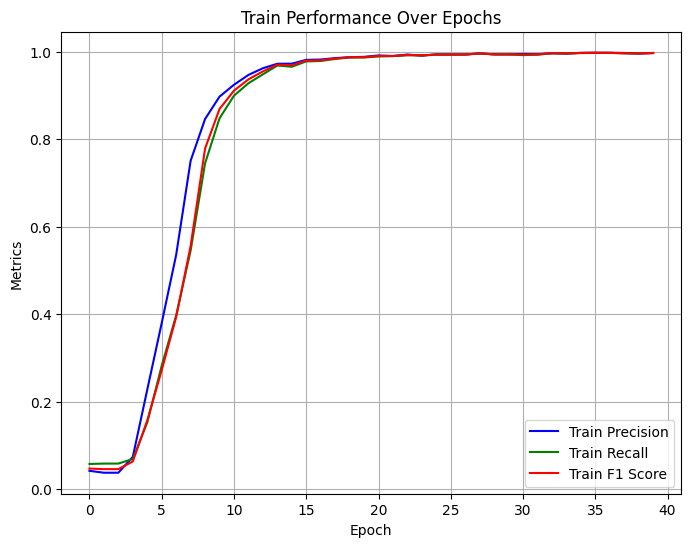

"plt.figure(figsize=(8, 6))\n\n#plt.plot(train_losses, label='Loss', marker='o', linestyle='--', color='black')\nplt.plot(val_precisions, label='Validation Precision',  linestyle='-', color='blue')\nplt.plot(val_recalls, label='Validation Recall',  linestyle='-', color='green')\nplt.plot(val_f1s, label='Validation F1 Score',  linestyle='-', color='red')\n\nplt.title('Validation Performance Over Epochs')\nplt.xlabel('Epoch')\nplt.ylabel('Metrics')\nplt.legend()\nplt.grid(True)\nplot_path = os.path.join(base_folder_name, 'Validation_Performance.png')\nplt.savefig(plot_path)  # Save the plot as a PNG file\nplt.show()\n\nplt.figure(figsize=(8, 6))\n\nplt.plot(train_losses, label='Train Loss')\nplt.plot(validation_loss_values, label='Validation Loss')\n\n\nplt.title('Training and validation Loss Over Epochs')\nplt.xlabel('Epoch')\nplt.ylabel('Metrics')\nplt.legend()\nplt.grid(True)\nplot_path = os.path.join(base_folder_name, 'Loss.png')\nplt.savefig(plot_path)  # Save the plot as a PNG file

In [ ]:
import matplotlib.pyplot as plt

train_precisions = [x[0] for x in train_metrics]
train_recalls = [x[1] for x in train_metrics]
train_f1s = [x[2] for x in train_metrics]

#val_precisions = [x[0] for x in validation_metrics]
#val_recalls = [x[1] for x in validation_metrics]
#val_f1s = [x[2] for x in validation_metrics]

#validation_loss_values = [loss.item() for loss in validation_losses]


plt.figure(figsize=(8, 6))

#plt.plot(train_losses, label='Loss', marker='o', linestyle='--', color='black')
plt.plot(train_precisions, label='Train Precision',  linestyle='-', color='blue')
plt.plot(train_recalls, label='Train Recall',  linestyle='-', color='green')
plt.plot(train_f1s, label='Train F1 Score',  linestyle='-', color='red')

plt.title('Train Performance Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.legend()
plt.grid(True)
plot_path = os.path.join(base_folder_name, 'Train_Performance.png')
plt.savefig(plot_path)  # Save the plot as a PNG file
plt.show()


'''plt.figure(figsize=(8, 6))

#plt.plot(train_losses, label='Loss', marker='o', linestyle='--', color='black')
plt.plot(val_precisions, label='Validation Precision',  linestyle='-', color='blue')
plt.plot(val_recalls, label='Validation Recall',  linestyle='-', color='green')
plt.plot(val_f1s, label='Validation F1 Score',  linestyle='-', color='red')

plt.title('Validation Performance Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.legend()
plt.grid(True)
plot_path = os.path.join(base_folder_name, 'Validation_Performance.png')
plt.savefig(plot_path)  # Save the plot as a PNG file
plt.show()

plt.figure(figsize=(8, 6))

plt.plot(train_losses, label='Train Loss')
plt.plot(validation_loss_values, label='Validation Loss')


plt.title('Training and validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.legend()
plt.grid(True)
plot_path = os.path.join(base_folder_name, 'Loss.png')
plt.savefig(plot_path)  # Save the plot as a PNG file
plt.show()'''


### End of Training ###

In [ ]:
import torch
import torch.nn.functional as F

def predict_sentence_all_layers_merged(model, sentence, tokenizer, device):
    # Tokenize the sentence
    tokenized_input = tokenizer(sentence, max_length=512,  truncation=True, is_split_into_words=False, padding=True, return_tensors="pt", return_offsets_mapping=True)
    input_ids = tokenized_input['input_ids'].to(device)
    attention_mask = tokenized_input['attention_mask'].to(device)
    offset_mapping = tokenized_input['offset_mapping'].squeeze().tolist()  # Get the offsets

    # Make prediction
    model.eval()
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)  # Outputs for each layer
    # Process each layer
    all_layer_results = []
    for layer_idx, logits in enumerate(outputs):
        probabilities = F.softmax(logits, dim=-1)
        scores, predictions = torch.max(probabilities, dim=-1)
        predictions = predictions.squeeze().tolist()
        scores = scores.squeeze().tolist()

        tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze().tolist())
        current_entity = None
        layer_results = []
        for i, (token, prediction, score, offset, mask) in enumerate(zip(tokens, predictions, scores, offset_mapping, attention_mask.squeeze().tolist())):
            if mask == 1:  # Only consider actual tokens, not padding
                entity_label = tag_list[prediction]
                base_entity_label = entity_label[2:] if entity_label.startswith(('B-', 'I-')) else entity_label
                if token.startswith("##"):
                    if current_entity:
                        # Extend the current entity
                        current_entity['text'] += token[2:]  # Remove the "##"
                        current_entity['end'] = offset[1]
                        current_entity['position'][-1] = f"{current_entity['start']} {current_entity['end']}"
                else:
                    if entity_label.startswith('B-') or entity_label == 'O':
                        if current_entity:
                            # Append the previous entity
                            layer_results.append(current_entity)
                            current_entity = None
                        if entity_label.startswith('B-'):
                            # Start a new entity
                            current_entity = {
                                'layer': layer_idx + 1,
                                'entity': base_entity_label,
                                'text': token,
                                'position': [f"{offset[0]} {offset[1]}"],
                                'start': offset[0],
                                'end': offset[1]
                            }
                    elif entity_label.startswith('I-') and current_entity and current_entity['entity'] == base_entity_label:
                        # Continue the current entity
                        current_entity['text'] += ' ' + token
                        current_entity['end'] = offset[1]
                        current_entity['position'][-1] = f"{current_entity['start']} {current_entity['end']}"
                    elif entity_label.startswith('I-') and (not current_entity or current_entity['entity'] != base_entity_label):
                        # Disjoint I-entity or mismatched tagging, start new
                        if current_entity:
                            # Append the previous entity
                            layer_results.append(current_entity)
                        current_entity = {
                            'layer': layer_idx + 1,
                            'entity': base_entity_label,
                            'text': token,
                            'position': [f"{offset[0]} {offset[1]}"],
                            'start': offset[0],
                            'end': offset[1]
                        }
        # Ensure the last entity is added
        if current_entity:
            layer_results.append(current_entity)

        all_layer_results.append(layer_results)

    return all_layer_results

# This function assumes you have already loaded and set up the `model`, `tokenizer`, and `device`,
# and that `tag_list` is defined as a list of tag names corresponding to the model's output indices.

# Example usage
sentence = """[Impact of bosentan therapy on stress-induced pulmonary hypertension in patients with systemic sclerosis].
AIM To describe hemodynamic and clinical changes in patients with elevated mean pulmonary artery pressure (MPAP) > 30 mm Hg during exercise and the impact of bosentan therapy on stress-induced pulmonary hypertension (SIPH).
SUBJECTS AND METHODS The study included 19 patients with systemic sclerosis (SDS) in whom possible causes of pulmonary hypertension (PH) (lung and left heart injuries and thromboembolism) were excluded.
All the patients underwent pulmonary artery catheterization at rest and during exercise.
The hemodynamic (right atrial pressure (RAP), systolic and diastolic pressure, MPAP, pulmonary artery wedge pressure (PAWP), cardiac output (CO) by a thermodilution technique), clinical (demographic, immunological, and instrumental) parameters were analyzed and the risk of pulmonary arterial hypertension (PAH) was also calculated; 5 patients with SIPH received 16-week bosentan therapy according to the conventional regimen.
RESULTS Ten of the 19 patients were at increased risk for PAH in accordance with the DETECT scale, but no signs of PH at resting catheterization were found in anybody.
In 5 patients, MPAP, was in the range from 21 to 24 mm Hg; in 9 (47%) patients were found to have SIPH, a median MPAP of 35 (32; 41) mm Hg.
Seven patients had no diagnostic changes during exercise; 3 patients could not perform an exercise test.
There were correlations between MPAP and DETECT risk scores (p < 0.05).
The patients with SIPH had significantly higher levels of resting MPAP and exercise pulmonary vascular resistance (PVR) and PAWP.
The calculated DETECT risk was significantly higher in the SIPH group.
The level of uric acid was also higher in the SIPH group (p < 0.05).
There were no changes in NT-proBNP levels, telangiectasias and anti-centromere antibodies, and EchoCG and lung test results.
During 16-week bosentan therapy, there was a significant decrease in MPAP and transpulmonary gradient during exercise, but PVR, MPAP/CO ratio and NT-proBNP levels tended to decrease.
CONCLUSION In the patients with SDS, SIPH may be a stage of pulmonary vasculopathy that precedes the development of clinical PAH.
The use of current PAH-specific drugs used at the preclinical stage of the disease may substantially improve lifetime prognosis in patients with SDS-associated PAH.
"""


predicted_tags = predict_sentence_all_layers_merged(model, sentence, tokenizer, device)
'''for layer_idx, layer_result in enumerate(predicted_tags):
    print(f"Layer {layer_idx + 1} predictions:")
    for tag in layer_result:
        print(tag)'''



# Flatten the list and remove empty entries
flattened_tags = [tag for sublist in predicted_tags if sublist for tag in sublist]

# Create a DataFrame
df = pd.DataFrame(flattened_tags)
# Modify the ID to be a serial number based on the index of the DataFrame
#df['ID'] = df.index.map(lambda x: f"T{x+1}_L{row['layer']}")


# Modify the DataFrame to adjust the 'position' field by removing the brackets
df['position'] = df['position'].apply(lambda x: x[0])
# Remove duplicate rows based on 'entity', 'position', and 'text' columns
df = df.drop_duplicates(subset=['entity', 'position', 'text'])
df['ID'] = df.apply(lambda row: f"T{row.name+1}_L{row['layer']}", axis=1)
# Display the updated DataFrame to confirm changes
# Copy specific columns from df to df2
df2 = df[['ID', 'entity', 'position', 'text']].copy()
# Filter out rows where the text column contains '[SEP]' or '[CLS]'
df2 = df2[~df2['text'].isin(['[SEP]', '[CLS]'])]
# Display the new DataFrame df2 to confirm the changes

# Display the updated DataFrame df2 to confirm that duplicates have been removed
df2



ID   entity position                                     text
0      T1_L1     CHEM    11 19                                 bosentan
1      T2_L1     DISO    31 68  stress - induced pulmonary hypertension
2      T3_L1     DISO   86 104                       systemic sclerosis
3      T4_L1     PHYS  123 134                              hemodynamic
4      T5_L1  FINDING  173 212  elevated mean pulmonary artery pressure
..       ...      ...      ...                                      ...
128  T129_L4  ANATOMY  187 196                                pulmonary
129  T130_L4  ANATOMY  197 203                                   artery
130  T131_L4  ANATOMY  483 488                                    heart
131  T132_L4  ANATOMY  897 906                                pulmonary
132  T133_L4  ANATOMY  907 915                                 arterial

[129 rows x 4 columns]

In [ ]:
df2.tail(40)

ID   entity   position                             text
89    T90_L2  ANATOMY    640 652                     right atrial
90    T91_L2     PHYS    653 661                         pressure
91    T92_L2     PHYS    692 700                         pressure
92    T93_L2  ANATOMY    708 724                 pulmonary artery
93    T94_L2     PHYS    731 739                         pressure
94    T95_L2  ANATOMY    748 755                          cardiac
95    T96_L2     DISO    897 928  pulmonary arterial hypertension
96    T97_L2     DISO  1108 1111                              pah
97    T98_L2     DISO  1165 1167                               ph
98    T99_L2  ANATOMY  1619 1637               pulmonary vascular
99   T100_L2     PHYS  1740 1748                         level of
100  T101_L2     CHEM  1749 1758                        uric acid
101  T102_L2     CHEM  1830 1839                      nt - probnp
102  T103_L2     CHEM  1884 1894                       antibodies
103  T104_L2  ANATOMY  1911 1915                             lung
105  T106_L2     PHYS  2058 2062                             mpap
106  T107_L2     PHYS  2063 2065                               co
107  T108_L2     CHEM  2076 2085                      nt - probnp
108  T109_L2  ANATOMY  2173 2182                        pulmonary
109  T110_L2     DISO  2183 2195                     vasculopathy
110  T111_L2     DISO  2238 2241                              pah
112  T113_L2     DISO  2403 2406                              pah
113  T114_L3  ANATOMY      46 55                        pulmonary
114  T115_L3     DISO      56 68                     hypertension
115  T116_L3  ANATOMY    187 203                 pulmonary artery
116  T117_L3  ANATOMY    300 309                        pulmonary
117  T118_L3     DISO    310 322                     hypertension
118  T119_L3  ANATOMY    478 488                       left heart
119  T120_L3     DISO    489 497                         injuries
120  T121_L3  ANATOMY    646 652                           atrial
121  T122_L3  ANATOMY    708 717                        pulmonary
122  T123_L3  ANATOMY    718 724                           artery
123  T124_L3  ANATOMY    897 915               pulmonary arterial
125  T126_L3  ANATOMY  1619 1628                        pulmonary
126  T127_L3  ANATOMY  1629 1637                         vascular
128  T129_L4  ANATOMY    187 196                        pulmonary
129  T130_L4  ANATOMY    197 203                           artery
130  T131_L4  ANATOMY    483 488                            heart
131  T132_L4  ANATOMY    897 906                        pulmonary
132  T133_L4  ANATOMY    907 915                         arterial

In [ ]:
import pandas as pd
import json



# Assuming model, tokenizer, and device are already set up
predicted_tags = predict_sentence_all_layers_merged(model, sentence, tokenizer, device)

# Flatten the list and remove empty entries
flattened_tags = [tag for sublist in predicted_tags if sublist for tag in sublist]

# Create a DataFrame
df = pd.DataFrame(flattened_tags)

# Process DataFrame for JSON conversion
df['position'] = df['position'].apply(lambda x: x[0])
df = df.drop_duplicates(subset=['entity', 'position', 'text'])
df['ID'] = df.apply(lambda row: f"T{row.name+1}_L{row['layer']}", axis=1)

# Create a new DataFrame for JSON output
df_json = pd.DataFrame()

# Add entities extracted from the DataFrame
df_json['entities'] = [df.apply(lambda row: [row['start'], row['end'], row['entity']], axis=1).tolist()]


# Add ID (assuming the entire content as one sentence for simplicity, modify as needed)
df_json['id'] = ["S1"]

# Add text for each unique sentence
df_json['text'] = [sentence]  # This could be adjusted if there are multiple sentences

# Convert DataFrame to JSON
output_json = df_json.to_dict(orient='records')
output_json_str = json.dumps(output_json)

print(output_json_str)


[{"entities": [[11, 19, "CHEM"], [31, 68, "DISO"], [86, 104, "DISO"], [123, 134, "PHYS"], [173, 212, "FINDING"], [214, 218, "PHYS"], [265, 273, "CHEM"], [285, 322, "DISO"], [324, 328, "DISO"], [388, 406, "DISO"], [408, 411, "DISO"], [440, 462, "DISO"], [464, 466, "DISO"], [469, 473, "ANATOMY"], [478, 497, "DISO"], [502, 517, "DISO"], [561, 577, "ANATOMY"], [627, 638, "PHYS"], [640, 661, "PHYS"], [663, 666, "PHYS"], [669, 677, "PHYS"], [682, 700, "PHYS"], [702, 706, "PHYS"], [708, 739, "PHYS"], [741, 745, "PHYS"], [748, 762, "PHYS"], [764, 766, "PHYS"], [773, 797, "LABPROC"], [889, 915, "FINDING"], [916, 928, "DISO"], [930, 933, "DISO"], [972, 976, "DISO"], [994, 1002, "CHEM"], [1089, 1111, "FINDING"], [1153, 1167, "FINDING"], [1233, 1237, "PHYS"], [1316, 1320, "DISO"], [1331, 1335, "PHYS"], [1377, 1398, "FINDING"], [1448, 1461, "LABPROC"], [1474, 1486, "FINDING"], [1495, 1499, "PHYS"], [1511, 1522, "FINDING"], [1553, 1557, "DISO"], [1576, 1589, "FINDING"], [1601, 1605, "PHYS"], [1619, 

In [ ]:
import pandas as pd
import json

# Assuming 'df' is already filled with the necessary data
df['entities'] = df.apply(lambda row: [row['start'], row['end'], row['entity'], row['text']], axis=1)

# Create a new DataFrame for the JSON output
df_json = pd.DataFrame()

# Add entities extracted from the DataFrame
df_json['entities'] = df['entities'].tolist()

# Add ID (assuming the entire content as one sentence for simplicity, modify as needed)
df_json['id'] = "S1"  # If DataFrame has multiple rows, this will broadcast the value 'S1' to all rows

# Add text for each unique sentence
df_json['text'] = [sentence] * len(df_json)  # Adjust to the number of rows

# Convert DataFrame to JSONL
output_jsonl = df_json.to_dict(orient='records')
output_jsonl_str = json.dumps(output_jsonl)  # Use indent for pretty printing

# Output the JSONL string
print(output_jsonl_str)


In [ ]:
import os
import pandas as pd
import torch
import json

# Assuming model, tokenizer, and device are already set up, add your model setup here

def process_files(input_directory, output_directory):
    all_data = []

    # Create the output directory if it doesn't exist
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    # Process each text file in the input directory
    for filename in os.listdir(input_directory):
        if filename.endswith(".txt"):
            file_path = os.path.join(input_directory, filename)
            with open(file_path, 'r', encoding='utf-8') as file:
                sentence = file.read()

                # Assume predict_sentence_all_layers_merged is defined as shown earlier
                predicted_tags = predict_sentence_all_layers_merged(model, sentence, tokenizer, device)
                # Flatten the list of predicted tags
                flattened_tags = [tag for sublist in predicted_tags if sublist for tag in sublist]

                # Create a DataFrame from the flattened tags
                if flattened_tags:
                    df = pd.DataFrame(flattened_tags)
                    if 'position' in df.columns:
                        df['position'] = df['position'].apply(lambda x: x[0] if x else '')
                    else:
                        df['position'] = ''  # Default to empty string if no position data

                    # Create a unique tuple for each entity for deduplication
                    df['entity_position'] = df.apply(lambda row: (row['start'], row['end'], row['entity']), axis=1)
                    df = df.drop_duplicates(subset=['entity_position', 'text'])
                else:
                    df = pd.DataFrame()

                # Prepare JSON output for each file
                if not df.empty:
                    entities = df[['start', 'end', 'entity', 'text']].to_dict(orient='records')
                else:
                    entities = []

                file_id = os.path.splitext(filename)[0]

                all_data.append({'entities': entities, 'id': file_id, 'text': sentence})

    # Save all data to a single JSON file
    output_path = os.path.join(output_directory, "test_output.jsonl")
    with open(output_path, 'w', encoding='utf-8') as f:
        json.dump(all_data, f, indent=1)

    print(f"All processed data saved to {output_path}")

# Define the input and output directories
input_directory = 'Dataset/DATASET_BIONNE_UPDATED/test_original/en'
output_directory = f'{base_folder_name}/test_orinigal_output_JSON/'  # Update this path as needed

# Call the function to process files
process_files(input_directory, output_directory)


In [ ]:
'''import os
import pandas as pd
import torch
import json

def process_files(input_directory, output_directory):
    all_data = []

    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    for filename in os.listdir(input_directory):
        if filename.endswith(".txt"):
            file_path = os.path.join(input_directory, filename)
            with open(file_path, 'r', encoding='utf-8') as file:
                sentence = file.read()

                predicted_tags = predict_sentence_all_layers_merged(model, sentence, tokenizer, device)
                flattened_tags = [tag for sublist in predicted_tags if sublist for tag in sublist]

                df = pd.DataFrame(flattened_tags)
                df['position'] = df['position'].apply(lambda x: x[0])
                df['entity_position'] = df.apply(lambda row: (row['start'], row['end'], row['entity']), axis=1)  # Convert to tuple
                df = df.drop_duplicates(subset=['entity_position', 'text'])

                # Prepare JSON output
                entities = df['entity_position'].tolist()
                id = os.path.splitext(filename)[0]
                text = sentence

                all_data.append({'entities': entities,'id': id, 'text': text})

    # Save all data to a single JSON file
    output_path = os.path.join(output_directory, "test_output.json")
    with open(output_path, 'w', encoding='utf-8') as f:
        json.dump(all_data,f)

    print(f"All processed data saved to {output_path}")

# Specify the input and output directories
input_directory = 'Dataset/DATASET_BIONNE_UPDATED/test_original/en'
output_directory = f'{base_folder_name}//test_orinigal_output_JSON/'  # Update this path as needed
process_files(input_directory, output_directory)
'''

In [ ]:
'''import os
import pandas as pd
import torch
import json

def process_files(input_directory, output_directory):
    all_data = []

    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    for filename in os.listdir(input_directory):
        if filename.endswith(".txt"):
            file_path = os.path.join(input_directory, filename)
            with open(file_path, 'r', encoding='utf-8') as file:
                sentence = file.read()

                predicted_tags = predict_sentence_all_layers_merged(model, sentence, tokenizer, device)
                flattened_tags = [tag for sublist in predicted_tags if sublist for tag in sublist]

                if flattened_tags and isinstance(flattened_tags[0], dict):
                    print("Flattened Tags Sample:", flattened_tags[0])  # Debug output

                # Handle missing columns by providing defaults if necessary
                df = pd.DataFrame(flattened_tags)
                if 'position' in df.columns:
                    df['position'] = df['position'].apply(lambda x: x[0])
                else:
                    print("Warning: 'position' column missing in data.")

                if all(col in df.columns for col in ['start', 'end', 'entity']):
                    df['entity_position'] = df.apply(lambda row: (row['start'], row['end'], row['entity']), axis=1)  # Convert to tuple
                    df = df.drop_duplicates(subset=['entity_position', 'text'])
                else:
                    print("Warning: One of 'start', 'end', or 'entity' columns is missing.")

                # Prepare JSON output
                entities = df['entity_position'].tolist() if 'entity_position' in df.columns else []
                id = os.path.splitext(filename)[0]
                text = sentence

                all_data.append({'entities': entities, 'id': id, 'text': text})

    # Save all data to a single JSON file
    output_path = os.path.join(output_directory, "test_output.json")
    with open(output_path, 'w', encoding='utf-8') as f:
        json.dump(all_data, f)

    print(f"All processed data saved to {output_path}")

# Example usage
input_directory = 'Dataset/DATASET_BIONNE_UPDATED/test_original/en'
output_directory = f'{base_folder_name}/test_orinigal_output_JSON/'  # Update this path as needed
process_files(input_directory, output_directory)
'''

In [ ]:
import os
import pandas as pd
import torch
import json

def process_files(input_directory, output_directory):
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    # Define the output file path
    output_path = os.path.join(output_directory, "test.jsonl")

    with open(output_path, 'w', encoding='utf-8') as f:
        for filename in os.listdir(input_directory):
            if filename.endswith(".txt"):
                file_path = os.path.join(input_directory, filename)
                with open(file_path, 'r', encoding='utf-8') as file:
                    sentence = file.read()

                    predicted_tags = predict_sentence_all_layers_merged(model, sentence, tokenizer, device)
                    flattened_tags = [tag for sublist in predicted_tags if sublist for tag in sublist]
                    if flattened_tags and isinstance(flattened_tags[0], dict):
                        print("Flattened Tags Sample:", flattened_tags[0])  # Debug output

                    df = pd.DataFrame(flattened_tags)
                    df['position'] = df['position'].apply(lambda x: x[0])
                    df['entity_position'] = df.apply(lambda row: (row['start'], row['end'], row['entity']), axis=1)  # Convert to tuple
                    df = df.drop_duplicates(subset=['entity_position', 'text'])

                    # Prepare JSON output
                    entities = df['entity_position'].tolist()
                    id = os.path.splitext(filename)[0]
                    text = sentence

                    json_data = {'entities': entities, 'id': id, 'text': text}
                    f.write(json.dumps(json_data) + '\n')  # Write each JSON object on a new line

    print(f"All processed data saved to {output_path}")

# Specify the input and output directories
input_directory = 'Datasets/BioASQ/test/en/'
output_directory = f'{base_folder_name}/test_original_output_JSONL/'  # Update this path as needed
process_files(input_directory, output_directory)


Flattened Tags Sample: {'layer': 1, 'entity': 'PHYS', 'text': 'age features', 'position': ['1 13'], 'start': 1, 'end': 13}
Flattened Tags Sample: {'layer': 1, 'entity': 'DISO', 'text': 'corneal damage', 'position': ['33 47'], 'start': 33, 'end': 47}
Flattened Tags Sample: {'layer': 1, 'entity': 'DISO', 'text': 'pre - stroke cognitive disorders', 'position': ['13 43'], 'start': 13, 'end': 43}
Flattened Tags Sample: {'layer': 1, 'entity': 'DISO', 'text': 'drowning', 'position': ['0 8'], 'start': 0, 'end': 8}
Flattened Tags Sample: {'layer': 1, 'entity': 'DISO', 'text': 'polyneuropathies', 'position': ['1 17'], 'start': 1, 'end': 17}
Flattened Tags Sample: {'layer': 1, 'entity': 'DISO', 'text': 'acute mesenteric ischaemia', 'position': ['27 53'], 'start': 27, 'end': 53}
Flattened Tags Sample: {'layer': 1, 'entity': 'LABPROC', 'text': 'clinical', 'position': ['3 11'], 'start': 3, 'end': 11}
Flattened Tags Sample: {'layer': 1, 'entity': 'FINDING', 'text': 'diagnostic value', 'position': ['1

In [ ]:
import os
import pandas as pd
import torch
import json

def process_files(input_directory, output_directory):
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    # Define the output file path
    output_path = os.path.join(output_directory, "test.jsonl")

    with open(output_path, 'w', encoding='utf-8') as f:
        for filename in os.listdir(input_directory):
            if filename.endswith(".txt"):
                file_path = os.path.join(input_directory, filename)
                with open(file_path, 'r', encoding='utf-8') as file:
                    sentence = file.read()

                    predicted_tags = predict_sentence_all_layers_merged(model, sentence, tokenizer, device)
                    flattened_tags = [tag for sublist in predicted_tags if sublist for tag in sublist]

                    # Debug output
                    print("Predicted Tags Sample:", predicted_tags)
                    print("Flattened Tags Sample:", flattened_tags)

                    if not flattened_tags:
                        continue  # Skip to the next file if there are no tags

                    df = pd.DataFrame(flattened_tags)

                    if 'position' in df.columns:
                        df['position'] = df['position'].apply(lambda x: x[0] if x else None)
                        df['entity_position'] = df.apply(lambda row: (row['start'], row['end'], row['entity']), axis=1)  # Convert to tuple
                        df = df.drop_duplicates(subset=['entity_position', 'text'])
                        df = df[~df['text'].isin(['[SEP]', '[CLS]'])]

                        # Prepare JSON output
                        entities = df['entity_position'].tolist()
                        id = os.path.splitext(filename)[0]
                        text = sentence

                        json_data = {'entities': entities, 'id': id, 'text': text}
                        f.write(json.dumps(json_data) + '\n')  # Write each JSON object on a new line
                    else:
                        print(f"Missing 'position' in data for file: {filename}")

    print(f"All processed data saved to {output_path}")


# Example usage
# Specify the input and output directories
input_directory = 'Datasets/BioASQ/test/en/'
output_directory = f'{base_folder_name}/test_original_output_JSONL/'  # Update this path as needed
process_files(input_directory, output_directory)



Predicted Tags Sample: [[{'layer': 1, 'entity': 'PHYS', 'text': 'age', 'position': ['1 4'], 'start': 1, 'end': 4}, {'layer': 1, 'entity': 'DISO', 'text': 'cytogenetic effects', 'position': ['17 36'], 'start': 17, 'end': 36}, {'layer': 1, 'entity': 'DISO', 'text': 'spring - summer encephalitis', 'position': ['40 66'], 'start': 40, 'end': 66}, {'layer': 1, 'entity': 'ANATOMY', 'text': 'northern', 'position': ['86 94'], 'start': 86, 'end': 94}, {'layer': 1, 'entity': 'ANATOMY', 'text': 'western siberia', 'position': ['95 110'], 'start': 95, 'end': 110}, {'layer': 1, 'entity': 'DISO', 'text': 'polymorphism for', 'position': ['130 146'], 'start': 130, 'end': 146}, {'layer': 1, 'entity': 'FINDING', 'text': 'genes of glutathione', 'position': ['147 167'], 'start': 147, 'end': 167}, {'layer': 1, 'entity': 'CHEM', 'text': '- s - transferase', 'position': ['167 181'], 'start': 167, 'end': 181}, {'layer': 1, 'entity': 'DISO', 'text': 'spring diseases', 'position': ['248 263'], 'start': 248, 'end'